# Понижение размерности

Существуют методы понижения размерности путем формирования новых признаков на основе старых. Новых признаков при использовании такого метода должно быть меньше, чем исходных, при условии сохранения максимально возможного количества информации из исходных признаков. Например, объединение нескольких признаков в линейную комбинацию:

$$z_{ij}=\sum_{k=1}^{n}w_{jk}x_{ik},$$

где $x_{ij}$ - исходные признаки, $z_{ij}$ - новые принаки.

### 1. Метод главных компонент

Суть метода заключается в приближении матрицы признаков матрицей меньшего ранга - так называемом низкоранговом приближении.

Запишем формулу линейного преобразования признаков в матричном виде:

$$Z = XW^{T},$$

где $X$ - матрица "объекты-признаки", где по строкам отложены объекты, а по столбцам - значения признаков, $Z$ - матрица новых признаков, $W^{T}$ - транспонированная матрица весов. Приближение заключается формировании новой матрицы признаков $\tilde{X}=ZW\approx X$ с возможностью восстанавливания старых признаков по новым с максимальным уровнем точности, или, если говорить иначе, чтобы их различие было минимальным:

$$\|ZW - X\|^{2} \rightarrow \underset{Z, W}{\text{min}}.$$

При этом метод главных компонент предполагает, что матрица весов должна быть ортогональной, то есть произведение $WW^{T}$ должно равняться единичной матрице. Восстановленная матрица $ZW$ может иметь ранг меньший, чем исходная $X$, поэтому приближение будет называться низкоранговым.

Геометрически метод можно представить как проецирование признаков на гиперплоскость с максимизацией дисперсии получаемой выборки.

![title](pca.png)

Если ранг матрицы исходных признаков $rank(X) \geq d$, где $d$ - число новых признаков, то минимум функционала различия, описанного выше, достигается тогда, когда в качестве строк матрицы $W$ используются собственные векторы матрицы $X^{T}X$ , соответствующие максимальным собственным значениям $\lambda_{1},...,\lambda_{d}$. Максимальные собственные значения и называются главными компонентами, от чего пошло название метода. Первая главная компонента соответствует максимальному собственному значению и т.д.

Таким образом, для реализации метода главных компонент нужно :
- найти собственные значения матрицы $X^{T}X$;
- отобрать $d$ максимальных;
- составить матрицу $W^{T}$, столбцы которой будут являться собственными векторами, соответствующими отобранным собственным значениям, расположенным в порядке убывания;
- получить новую матрицу "объекты-признаки", умножив исходную матрицу $X$ на матрицу весов $W$:

$$Z=XW.$$

В новой матрице $Z$ сможем увидеть, какие признаки объясняют большую долю дисперсии в общей выборке.

![title](boxplots.png)

### 2.PCA и SVD

Нельзя не заметить родство PCA с сингулярным разложением матриц (SVD). Cингулярное разложение матрицы - это разложение вида

$$X=UDV^{T},$$

где столбцы ортогональной матрицы $U$ - это собственные векторы матрицы $XX^{T}$, столбцы ортогональной матрицы $V$ - собственные векторы матрицы $X^{T}X$, а на главной диагонали диагональной матрицы $D$ расположены собственные значения матриц $XX^{T}$ и $X^{T}X$ (они равны и также называются сингулярными числами матрицы $X$).

Если число новых признаков $d$ равно старому числу признаков $n$, то можно приравнять разложения

$$X=ZW=UDV^{T}.$$

При этом матрицы $W$ и $V^{T}$ состоят из собственных векторов матрицы $X^{T}X$, то есть они равны при $Z=UD$.

Получается, что метод главных компонент - в своем роде "урезанная версия" сингулярного разложения, из которого убрали минимальные собственные значения с соответствующими собственными векторами. 
Таким образом, для реализации понижения размерности методом главных компонент с помощью SVD нужно:
- найти сингулярное разложение вектора $X$;
- сформировать из столбцов матрицы $V$, соответствующих $d$ наибольшим сингулярным числам, матрицу весов $W$;
- получить новую матрицу "объекты-признаки", умножив исходную матрицу $X$ на матрицу весов $W$:

$$Z=XW.$$

### 3. Примеры реализации

In [224]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from itertools import product

In [2]:
iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

### 3.1. PCA

Для начала отмасштабируем выборку.

In [3]:
X_ = X.astype(float)
rows, cols = X_.shape

In [4]:
# центрирование - вычитание из каждого значения среднего по строке
def centering(data, rows, cols):
    means = data.mean(0)
    for i in range(rows):
        for j in range(cols):
            X_[i, j] -= means[j]

In [5]:
# деление каждого значения на стандартное отклонение
def standartization(data, rows, cols):
    std = np.std(data, axis=0)
    for i in range(cols):
        for j in range(rows):
            X_[j][i] /= std[i]

In [6]:
centering(X_, rows, cols)

In [7]:
standartization(X_, rows, cols)

Найдём собственные векторы и собственные значения.

In [59]:
covariance_matrix = X_.T.dot(X_)
eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

Сформируем список значений собственное значение-собственный вектор.

In [60]:
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

Отсортируем список по убыванию собственных значений.

In [10]:
eig_pairs.sort(key=lambda x: x[0], reverse=True)
print('Собственные значения в порядке убывания:')
for i in eig_pairs:
    print(i[0])

Собственные значения в порядке убывания:
437.7746724797988
137.10457072021055
22.013531335697195
3.107225464292886


Оценим долю дисперсии, которая описывается найденными компонентами.

In [11]:
eig_sum = sum(eig_values)
var_exp = [(i/eig_sum)*100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описвыаемая каждой из компонент \n{var_exp}')

Доля дисперсии, описвыаемая каждой из компонент 
[72.96244541329987, 22.850761786701778, 3.6689218892828697, 0.5178709107154814]


Оценим кумулятивную дисперсию.

In [12]:
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


Таким образом, первая главная компонента описывает почти 73% информации, а первые две в сумме - 95.8%. В то же время последняя компонента описывает всего 0.5% и может быть отброшена без страха значительных потерь в качестве нашего анализа. Мы отбросим последние две компоненты, оставив первые две.

Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам.

In [13]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


Сформируем новую матрицу "объекты-признаки".

In [14]:
Z = X_.dot(W)

In [15]:
def pca_plot(new_data):
    plt.figure()
    y = iris.target
    for c, i in zip("rgb", [0, 1, 2]):
        plt.scatter(new_data[y==i, 0], new_data[y==i, 1], c=c)
    plt.xlabel('Главная компонента 1')
    plt.ylabel('Главная компонента 2')
    plt.title('PCA датасета IRIS')
    plt.show()

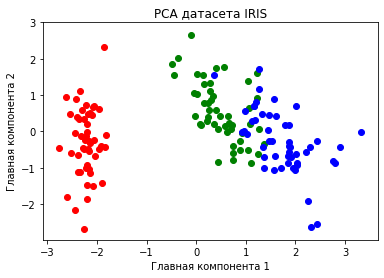

In [16]:
pca_plot(Z)

Таким образом, мы перешли от четырехмерного пространства признаков к двумерному и при этом классы остались разделимы в пространстве, то есть классификация возможна.

PCA наиболее хорошо работает, когда собственные значения $\lambda$ на каком-то участке графика распределения убывают скачкообразно (критерий крутого склона), другими словами, если существуют предпосылки к тому, что следует решать задачу в пространстве меньшей размерности. Если же они убывают монотонно, следует рассмотреть вариант использования других методов работы с пространством признаков.

### 3.2. PCA c использованием SVD

Найдём сингулярное разложение X.

In [170]:
U, s, v = np.linalg.svd(X_)

In [171]:
V = v.T

In [172]:
V

array([[ 0.52106591, -0.37741762,  0.71956635,  0.26128628],
       [-0.26934744, -0.92329566, -0.24438178, -0.12350962],
       [ 0.5804131 , -0.02449161, -0.14212637, -0.80144925],
       [ 0.56485654, -0.06694199, -0.63427274,  0.52359713]])

Сформируем матрицу весов W из столбцов матрицы V, которые соответствуют двум наибольшим сингулярным числам.

In [193]:
d = 2 #максимальное количество сингулярных чисел

In [194]:
sing_values = np.array([np.abs(V[i]) for i in range(len(V))])

In [195]:
sing_values

array([[0.52106591, 0.37741762, 0.71956635, 0.26128628],
       [0.26934744, 0.92329566, 0.24438178, 0.12350962],
       [0.5804131 , 0.02449161, 0.14212637, 0.80144925],
       [0.56485654, 0.06694199, 0.63427274, 0.52359713]])

In [196]:
ind_col = np.argmax(sing_values, axis = 1)
ind_col = np.expand_dims(ind_col, axis = 0)
maximum = np.take_along_axis(sing_values, ind_col, axis = 0)

In [197]:
maximum

array([[0.5804131 , 0.92329566, 0.63427274, 0.80144925]])

In [198]:
max_ind = maximum.argsort()[-d:][-1][d:]
max_ind

array([3, 1], dtype=int64)

In [199]:
W = np.hstack((sing_values[:, max_ind[0]].reshape(4,1), sing_values[:, max_ind[1]].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[0.26128628 0.37741762]
 [0.12350962 0.92329566]
 [0.80144925 0.02449161]
 [0.52359713 0.06694199]]


Сформируем новую матрицу "объекты-признаки".

In [200]:
Z = X_.dot(W)

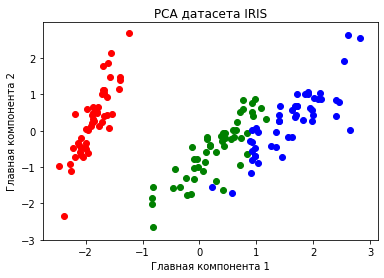

In [201]:
pca_plot(Z)